This notebook is solely used for visualization purpose

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from src import modeling_functions as mfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import recall_score, f1_score, make_scorer

In [2]:
df = cfs.cleaned_dataframe()

In [3]:
df.groupby('district_id').count().head()

,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
district_id,,,,,,,,,,,,,,,,,,,,,
12,39352,39352,39352,39352,39352,39352,39352,39352,39352,39352,...,39352,39352,39352,39352,39352,39352,39352,39352,39352,39352
20,68748,68748,68748,68748,68748,68748,68748,68748,68748,68748,...,68748,68748,68748,68748,68748,68748,68748,68748,68748,68748
21,58612,58612,58612,58612,58612,58612,58612,58612,58612,58612,...,58612,58612,58612,58612,58612,58612,58612,58612,58612,58612
22,60639,60639,60639,60639,60639,60639,60639,60639,60639,60639,...,60639,60639,60639,60639,60639,60639,60639,60639,60639,60639
23,88741,88741,88741,88741,88741,88741,88741,88741,88741,88741,...,88741,88741,88741,88741,88741,88741,88741,88741,88741,88741


In [4]:
df_districts = df.copy()

In [5]:
df_districts['damage_grade_1'] = df_districts[df_districts['target'] == 1].target
df_districts['damage_grade_2'] = df_districts[df_districts['target'] == 2].target
df_districts['damage_grade_3'] = df_districts[df_districts['target'] == 3].target

In [6]:
df_districts = df_districts.groupby('district_id').agg({'vdcmun_id': 'count',
                                         'damage_grade_1': 'count',
                                         'damage_grade_2':'count',
                                         'damage_grade_3':'count'})

In [7]:
df_districts

,vdcmun_id,damage_grade_1,damage_grade_2,damage_grade_3
district_id,,,,
12,39352,16566,9220,13566
20,68748,27555,17085,24108
21,58612,9267,16945,32400
22,60639,4346,6520,49773
23,88741,3242,3271,82228
24,98019,20056,25130,52833
28,77148,5360,8209,63579
29,12644,620,782,11242
30,89122,12478,15218,61426


In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

data = gpd.read_file(r"../../data/nepal_data/NP_75DWGS84.shp")

type(data)

data

,DIST_ID,DISTRICT,ZONE_NAME,REGION,DISS,Xc,Yc,geometry
0,1,Taplejung,Mechi,Eastern,100,87.8217,27.5822,"POLYGON ((87.83401 27.95177, 87.83462 27.95159..."
1,2,Panchthar,Mechi,Eastern,100,87.7757,27.1151,"POLYGON ((88.07356 27.43372, 88.07440 27.43332..."
2,3,Ilam,Mechi,Eastern,100,87.9014,26.8813,"POLYGON ((87.99488 27.10368, 87.99512 27.10364..."
3,4,Jhapa,Mechi,Eastern,100,87.9131,26.5847,"POLYGON ((88.15220 26.80604, 88.15278 26.80555..."
4,5,Morang,Koshi,Eastern,100,87.4701,26.6176,"POLYGON ((87.50696 26.87060, 87.50736 26.86978..."
...,...,...,...,...,...,...,...,...
70,71,Kailali,Seti,Far-Western,100,80.8790,28.7418,"POLYGON ((80.56591 29.06232, 80.56619 29.06230..."
71,72,Kanchanpur,Mahakali,Far-Western,100,80.3216,28.8619,"POLYGON ((80.18673 29.12741, 80.18668 29.12678..."
72,73,Dadeldhura,Mahakali,Far-Western,100,80.4889,29.2232,"POLYGON ((80.69008 29.42242, 80.69041 29.42232..."
73,74,Baitadi,Mahakali,Far-Western,100,80.5714,29.5077,"POLYGON ((80.75732 29.70589, 80.75832 29.70465..."


In [12]:
data_districts = pd.merge(data, df_districts, left_on='DIST_ID', right_on='district_id')

In [13]:
data_districts.rename(columns={'vdcmun_id': 'buildings'}, inplace=True)

In [14]:
data_districts['grade_3_rate'] = data_districts['damage_grade_3']/data_districts['buildings']

In [17]:
import plotly.express as px

In [62]:
import json
import requests
#with urlopen('https://github.com/mesaugat/geoJSON-Nepal/raw/master/nepal-districts-new.geojson') as response:
response = requests.get('https://github.com/mesaugat/geoJSON-Nepal/raw/master/nepal-districts.geojson')
nepal_districts = response.json()

nepal_districts["features"][0]['properties']

{'type': 'Feature',
 'id': 0,
 'properties': {'DISTRICT': 'HUMLA'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[81.40184783935547, 30.359201431274414],
    [81.40120697021484, 30.360641479492188],
    [81.4002456665039, 30.362661361694336],
    [81.39794921875, 30.363842010498047],
    [81.39568328857422, 30.3673095703125],
    [81.39769744873047, 30.369009017944336],
    [81.40133666992188, 30.369264602661133],
    [81.40563201904297, 30.368925094604492],
    [81.4099349975586, 30.369173049926758],
    [81.41324615478516, 30.369422912597656],
    [81.41720581054688, 30.368810653686523],
    [81.42052459716797, 30.36963653564453],
    [81.42353820800781, 30.372188568115234],
    [81.424560546875, 30.3739070892334],
    [81.42459869384766, 30.376779556274414],
    [81.42494201660156, 30.37763214111328],
    [81.4266128540039, 30.378767013549805],
    [81.42864227294922, 30.381616592407227],
    [81.4280014038086, 30.383066177368164],
    [81.42469787597656, 30.38309669494629],


In [69]:
district_list = []
for i in range(75):
    district_list.append(nepal_districts["features"][i]['properties']['DISTRICT'].lower().capitalize())

In [70]:
district_list

['Humla',
 'Darchula',
 'Bajhang',
 'Mugu',
 'Bajura',
 'Baitadi',
 'Dolpa',
 'Jumla',
 'Kalikot',
 'Doti',
 'Dadeldhura',
 'Achham',
 'Mustang',
 'Dailekh',
 'Jajarkot',
 'Kanchanpur',
 'Kailali',
 'Rukum',
 'Surkhet',
 'Manang',
 'Myagdi',
 'Gorkha',
 'Bardiya',
 'Salyan',
 'Baglung',
 'Kaski',
 'Rolpa',
 'Lamjung',
 'Parbat',
 'Rasuwa',
 'Pyuthan',
 'Dhading',
 'Banke',
 'Gulmi',
 'Dang',
 'Syangja',
 'Sindhupalchok',
 'Dolakha',
 'Tanahu',
 'Arghakhanchi',
 'Solukhumbu',
 'Nuwakot',
 'Sankhuwasabha',
 'Palpa',
 'Taplejung',
 'Chitwan',
 'Nawalparasi',
 'Kapilbastu',
 'Ramechhap',
 'Kathmandu',
 'Rupandehi',
 'Kavre',
 'Bhaktapur',
 'Makwanpur',
 'Lalitpur',
 'Okhaldhunga',
 'Bhojpur',
 'Parsa',
 'Sindhuli',
 'Khotang',
 'Panchthar',
 'Bara',
 'Tehrathum',
 'Rautahat',
 'Dhankuta',
 'Sarlahi',
 'Udayapur',
 'Mahottari',
 'Ilam',
 'Dhanusa',
 'Siraha',
 'Saptari',
 'Morang',
 'Sunsari',
 'Jhapa']

In [104]:
data3 = data.set_index('DISTRICT')

In [97]:
data3.head()

,DIST_ID,ZONE_NAME,REGION,DISS,Xc,Yc,geometry
DISTRICT,,,,,,,
Taplejung,1,Mechi,Eastern,100,87.8217,27.5822,"POLYGON ((87.83401 27.95177, 87.83462 27.95159..."
Panchthar,2,Mechi,Eastern,100,87.7757,27.1151,"POLYGON ((88.07356 27.43372, 88.07440 27.43332..."
Ilam,3,Mechi,Eastern,100,87.9014,26.8813,"POLYGON ((87.99488 27.10368, 87.99512 27.10364..."
Jhapa,4,Mechi,Eastern,100,87.9131,26.5847,"POLYGON ((88.15220 26.80604, 88.15278 26.80555..."
Morang,5,Koshi,Eastern,100,87.4701,26.6176,"POLYGON ((87.50696 26.87060, 87.50736 26.86978..."


In [95]:
data.DISTRICT.replace('Chitawan', 'Chitwan', inplace=True)

In [99]:
data.DISTRICT.unique()

array(['Taplejung', 'Panchthar', 'Ilam', 'Jhapa', 'Morang', 'Sunsari',
       'Dhankuta', 'Terhathum', 'Sankhuwasabha', 'Bhojpur', 'Solukhumbu',
       'Okhaldhunga', 'Khotang', 'Udayapur', 'Saptari', 'Siraha',
       'Dhanusa', 'Mahottari', 'Sarlahi', 'Sindhuli', 'Ramechhap',
       'Dolakha', 'Sindhupalchok', 'Kavrepalanchok', 'Lalitpur',
       'Bhaktapur', 'Kathmandu', 'Nuwakot', 'Rasuwa', 'Dhading',
       'Makwanpur', 'Rautahat', 'Bara', 'Parsa', 'Chitwan', 'Gorkha',
       'Lamjung', 'Tanahu', 'Syangja', 'Kaski', 'Manang', 'Mustang',
       'Myagdi', 'Parbat', 'Baglung', 'Gulmi', 'Palpa', 'Nawalparasi',
       'Rupandehi', 'Kapilbastu', 'Arghakhanchi', 'Pyuthan', 'Rolpa',
       'Rukum', 'Salyan', 'Dang', 'Banke', 'Bardiya', 'Surkhet',
       'Dailekh', 'Jajarkot', 'Dolpa', 'Jumla', 'Kalikot', 'Mugu',
       'Humla', 'Bajura', 'Bajhang', 'Achham', 'Doti', 'Kailali',
       'Kanchanpur', 'Dadeldhura', 'Baitadi', 'Darchula'], dtype=object)

In [100]:
data.DISTRICT.replace('Kavrepalanchok', 'Kavre', inplace=True)

In [103]:
data.DISTRICT.replace('Terhathum', 'Tehrathum', inplace=True)

In [105]:
data4 = pd.DataFrame(columns=['DIST_ID','ZONE_NAME','REGION','DISS','Xc','Yc','geometry'])

for name in district_list:
    data4.loc[name] = data3.loc[name]
    

In [109]:
data4['DISTRICT_NAMES'] = data4.index

In [46]:
data.head()

,DIST_ID,DISTRICT,ZONE_NAME,REGION,DISS,Xc,Yc,geometry
0,1,Taplejung,Mechi,Eastern,100,87.8217,27.5822,"POLYGON ((87.83401 27.95177, 87.83462 27.95159..."
1,2,Panchthar,Mechi,Eastern,100,87.7757,27.1151,"POLYGON ((88.07356 27.43372, 88.07440 27.43332..."
2,3,Ilam,Mechi,Eastern,100,87.9014,26.8813,"POLYGON ((87.99488 27.10368, 87.99512 27.10364..."
3,4,Jhapa,Mechi,Eastern,100,87.9131,26.5847,"POLYGON ((88.15220 26.80604, 88.15278 26.80555..."
4,5,Morang,Koshi,Eastern,100,87.4701,26.6176,"POLYGON ((87.50696 26.87060, 87.50736 26.86978..."


In [34]:
new_districts

'nepal-districts-new'

In [ ]:
fig = px.choropleth_mapbox(data4, geojson=nepal_districts, locations='DISTRICT_NAMES', color='DIST_ID',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=6, center={"lat": 28.3, "lon": 84.32},
                           opacity=0.5
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

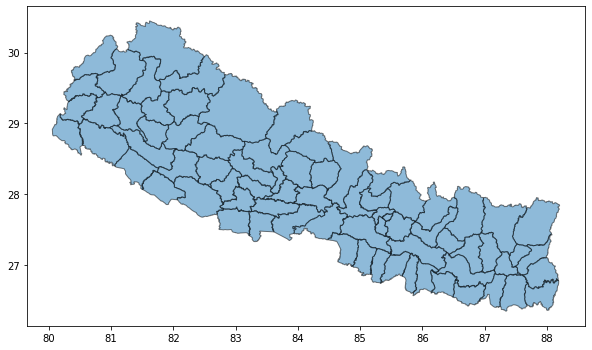

In [5]:
data.plot(figsize=(10, 10), alpha=0.5, edgecolor='k');

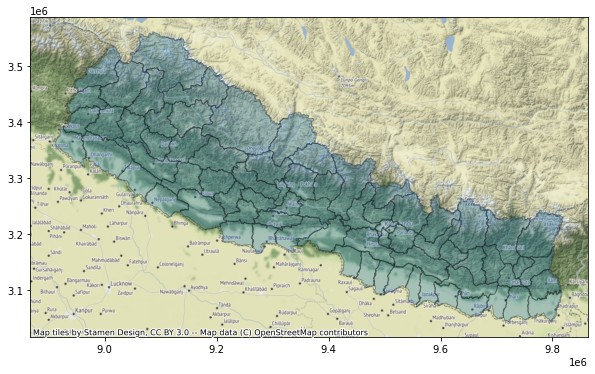

In [6]:
data = data.to_crs(epsg=3857)
import contextily as ctx
ax = data.plot(figsize=(10, 10), alpha=0.3, edgecolor='k')
ctx.add_basemap(ax)

In [7]:
districts = ['Okhaldhunga','Sindhuli','Ramechhap','Dolakha',
             'Sindhupalchok','Kavrepalanchok','Nuwakot',
             'Rasuwa','Dhading','Makwanpur', 'Gorkha']

data2 = data[data['DISTRICT'].isin(districts)]

In [8]:
df = gpd.overlay(data, data2, how='union')

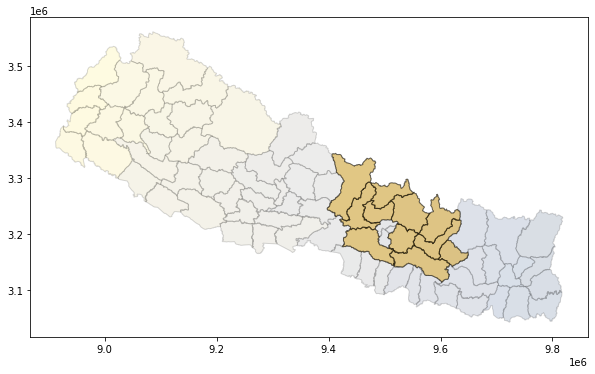

In [9]:
f, ax = plt.subplots(figsize=(10,10))
data.plot(alpha=0.15, edgecolor='k', ax=ax, cmap='cividis')
data2.plot(alpha=0.5, edgecolor='k', color='goldenrod', ax=ax);

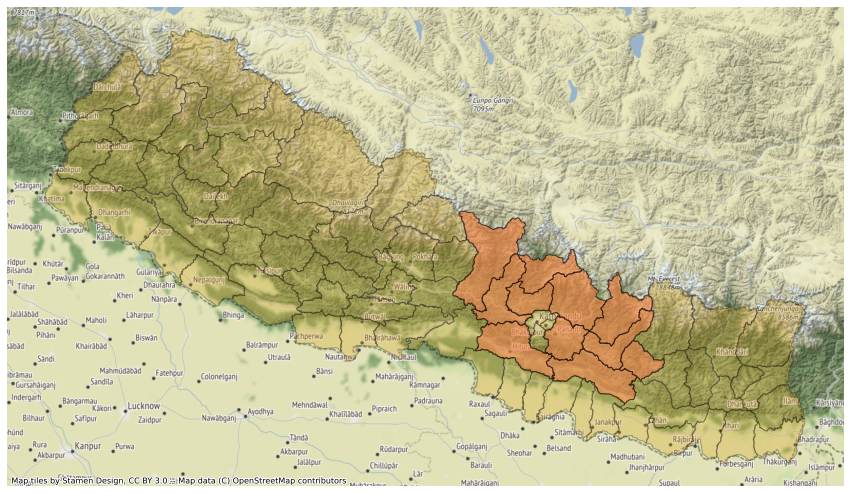

In [10]:
data = data.to_crs(epsg=3857)
f, ax = plt.subplots(figsize=(15,15))
data.plot(alpha=0.3, edgecolor='k', ax=ax, color='goldenrod')
data2.plot(alpha=0.5, edgecolor='k', color='coral', ax=ax)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.savefig('../../report/figures/11_districts_nepal.png', format='png', transparent=True)

In [50]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [51]:
df = cfs.cleaned_dataframe()

In [52]:
str_df, ow_df, ward_df = cfs.load_raw_files()

In [53]:
df.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,2.0
120101000021,12,1207,120703,1,15,364,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,3.0
120101000031,12,1207,120703,1,20,384,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000041,12,1207,120703,1,20,312,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000051,12,1207,120703,1,30,308,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0


In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [55]:
df.foundation_type.unique()

array(['other', 'mud_mortar_stone_or_brick', 'cement_stone_or_brick',
       'bamboo_or_timber', 'rc'], dtype=object)

No handles with labels found to put in legend.


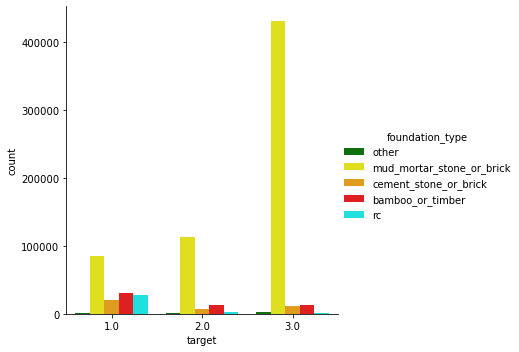

In [69]:
fig, ax = plt.subplots(figsize=(20,15))

sns.catplot("target", hue="foundation_type", data=df, kind="count", 
            palette={'mud_mortar_stone_or_brick':"yellow",
                     'cement_stone_or_brick':"orange",
                     'bamboo_or_timber':"red", 'rc':'cyan',
                     'other':'green'}, ax=ax)


ax.legend(title="Foundation Type")
ax.set_xticklabels(['damage grade 1', 'damage grade 2', 'damage grade 3'])
#ax.set_xlabel("")
plt.close(1) # catplot creates an extra figure we don't need

#fig.suptitle("Passenger Class vs. Survival for Titanic Passengers");

In [71]:
counts_df = df.groupby(["foundation_type", "target"])["district_id"].count().unstack()
counts_df

target,1.0,2.0,3.0
foundation_type,,,
bamboo_or_timber,30557,13244,13670
cement_stone_or_brick,20489,7104,11652
mud_mortar_stone_or_brick,85528,112442,430735
other,1769,459,2324
rc,27728,3163,1229


In [72]:
foundation_percents_df = counts_df.div(counts_df.sum()).T
foundation_percents_df

foundation_type,bamboo_or_timber,cement_stone_or_brick,mud_mortar_stone_or_brick,other,rc
target,,,,,
1.0,0.184000,0.123375,0.515009,0.010652,0.166965
2.0,0.097088,0.052078,0.824282,0.003365,0.023187
3.0,0.029743,0.025352,0.937175,0.005056,0.002674


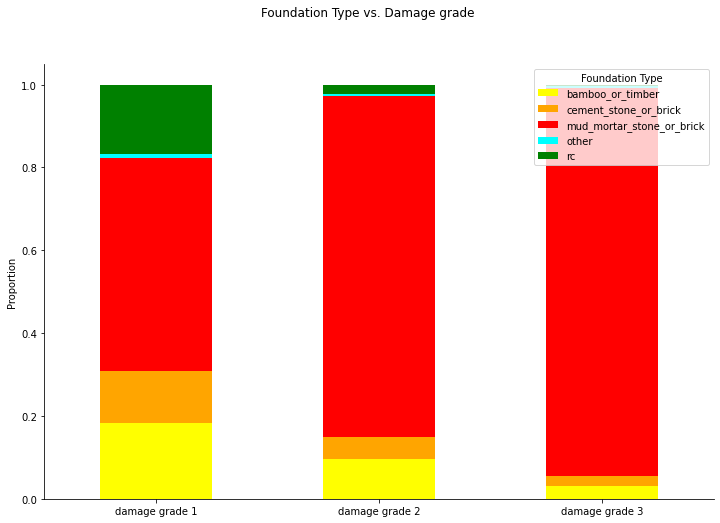

In [76]:
fig, ax = plt.subplots(figsize=(12,8))

foundation_percents_df.plot(kind="bar", stacked=True, color=["yellow", "orange", "red", 'cyan', 'green'], ax=ax)

ax.legend(title="Foundation Type", loc='upper right')
ax.set_xticklabels(["damage grade 1", "damage grade 2", "damage grade 3"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Proportion")
sns.despine()
fig.suptitle("Foundation Type vs. Damage grade");

In [77]:
damage_percents_df = counts_df.T.div(counts_df.T.sum()).T
damage_percents_df

target,1.0,2.0,3.0
foundation_type,,,
bamboo_or_timber,0.531694,0.230447,0.237859
cement_stone_or_brick,0.522079,0.181017,0.296904
mud_mortar_stone_or_brick,0.136038,0.178847,0.685115
other,0.388620,0.100835,0.510545
rc,0.863263,0.098474,0.038263


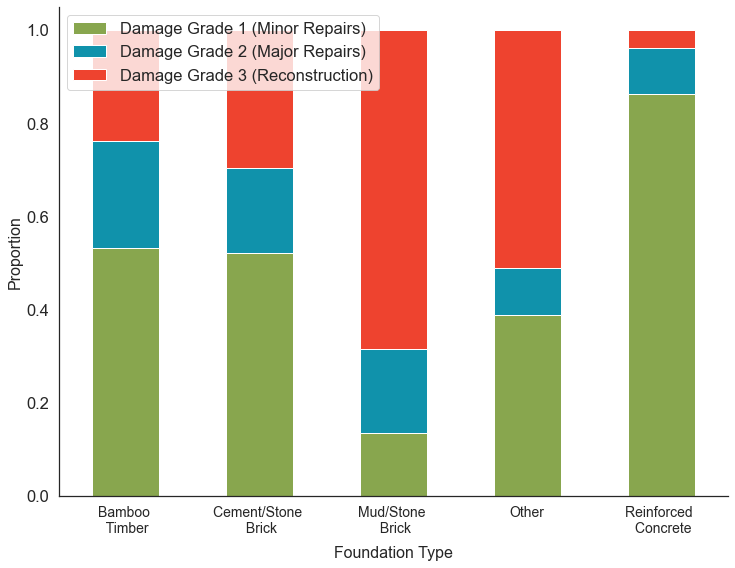

In [129]:
fig, ax = plt.subplots(figsize=(12,9))

damage_percents_df.plot(kind="bar", stacked=True, color=['#88A64E', '#1092AB', '#EE432F'], ax=ax)

ax.set_xlabel("Foundation Type", fontsize=16, labelpad=10)
ax.set_xticklabels(['Bamboo \n Timber', 'Cement/Stone \n Brick', 'Mud/Stone \n Brick', 'Other', 'Reinforced \n Concrete'], rotation=0, fontsize=14)
ax.set_ylabel("Proportion", fontsize=16)

color_patches = [
    Patch(facecolor="#88A64E", label="Damage Grade 1 (Minor Repairs)"),
    Patch(facecolor='#1092AB', label="Damage Grade 2 (Major Repairs)"),
    Patch(facecolor='#EE432F', label="Damage Grade 3 (Reconstruction)")
]
ax.legend(handles=color_patches, loc='upper left')
sns.despine()
#fig.suptitle("Foundation Type vs. Damage Grade")
fig.savefig('../../report/figures/foundation_type.png', format='png', transparent=True)
plt.show();

In [107]:
damage_counts_df = df.groupby("target")["district_id"].count()
damage_counts_df

target
1.0    166071
2.0    136412
3.0    459610
Name: district_id, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))


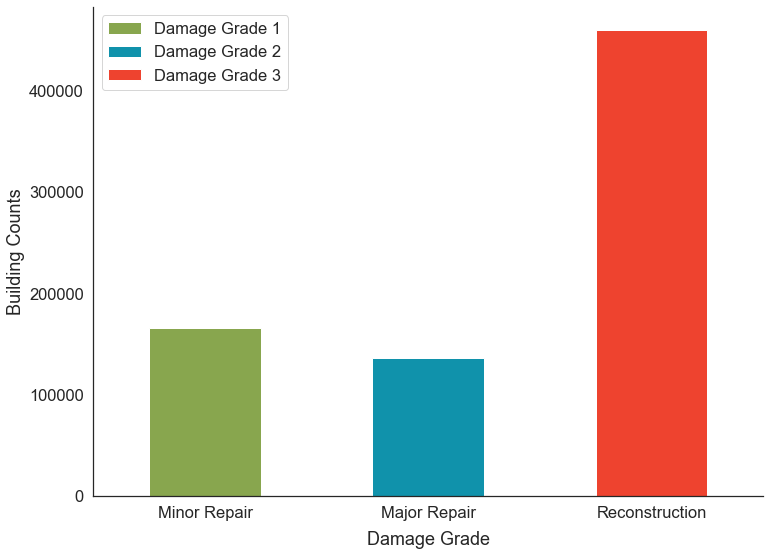

In [127]:
fig, ax = plt.subplots(figsize=(12,9))
damage_counts_df.plot(kind="bar", color=['#88A64E', '#1092AB', '#EE432F'], ax=ax)


ax.set_xticklabels(['Minor Repair', 'Major Repair', 'Reconstruction'], rotation=0)
ax.set_xlabel('Damage Grade', labelpad = 10)
ax.set_ylabel('Building Counts')

color_patches = [
    Patch(facecolor="#88A64E", label="Damage Grade 1"),
    Patch(facecolor='#1092AB', label="Damage Grade 2"),
    Patch(facecolor='#EE432F', label="Damage Grade 3")
]
ax.legend(handles=color_patches)
sns.despine()
fig.savefig('../../report/figures/building_damage_grades.png', format='png', transparent=True)
plt.show();

In [118]:
roof_counts_df = df.groupby(["roof_type", "target"])["district_id"].count().unstack()
roof_counts_df

target,1.0,2.0,3.0
roof_type,,,
bamboo_or_timber_heavy_roof,35892,41267,136615
bamboo_or_timber_light_roof,93540,89821,320374
rcc_or_rb_or_rbc,36639,5324,2621


In [119]:
roof_percents_df = roof_counts_df.div(roof_counts_df.sum()).T
roof_percents_df

roof_type,bamboo_or_timber_heavy_roof,bamboo_or_timber_light_roof,rcc_or_rb_or_rbc
target,,,
1.0,0.216124,0.563253,0.220623
2.0,0.302517,0.658454,0.039029
3.0,0.297241,0.697056,0.005703


In [120]:
damage_roof_percents_df = roof_counts_df.T.div(roof_counts_df.T.sum()).T
damage_roof_percents_df

target,1.0,2.0,3.0
roof_type,,,
bamboo_or_timber_heavy_roof,0.167897,0.193040,0.639063
bamboo_or_timber_light_roof,0.185693,0.178310,0.635997
rcc_or_rb_or_rbc,0.821797,0.119415,0.058788


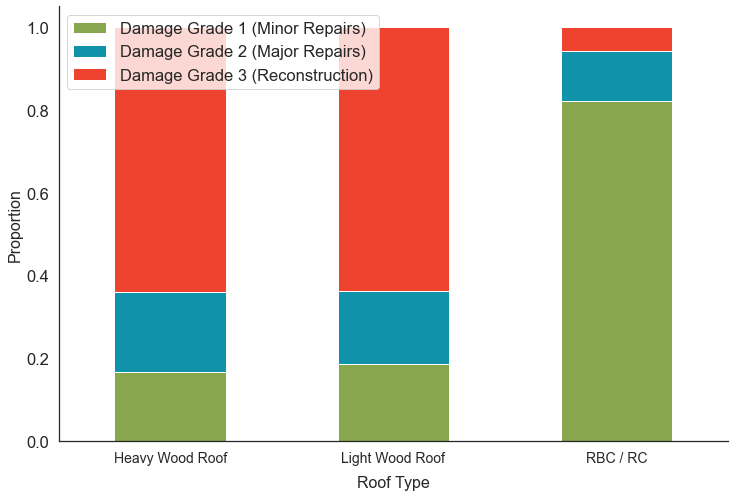

In [126]:
fig, ax = plt.subplots(figsize=(12,8))

damage_roof_percents_df.plot(kind="bar", stacked=True, color=['#88A64E', '#1092AB', '#EE432F'], ax=ax)

ax.set_xlabel("Roof Type", fontsize=16, labelpad=10)
ax.set_xticklabels(['Heavy Wood Roof', 'Light Wood Roof', 'RBC / RC'], rotation=0, fontsize=14)
ax.set_ylabel("Proportion", fontsize=16)

color_patches = [
    Patch(facecolor="#88A64E", label="Damage Grade 1 (Minor Repairs)"),
    Patch(facecolor='#1092AB', label="Damage Grade 2 (Major Repairs)"),
    Patch(facecolor='#EE432F', label="Damage Grade 3 (Reconstruction)")
]
ax.legend(handles=color_patches, loc='upper left')
sns.despine()
#fig.suptitle("Foundation Type vs. Damage Grade")
fig.savefig('../../report/figures/roof_type.png', format='png', transparent=True)
plt.show();

In [ ]:
#interactive plots with bokeh and geopandas
#https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-bokeh.html